In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
from tqdm.notebook import tqdm
from collections import Counter
from fuzzywuzzy import process

## Load the data

In [2]:
df_vaers_data = pd.read_csv('./2023VAERSData/2023VAERSDATA.csv', encoding='latin-1')
df_vaers_data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,2547730,01/01/2023,DE,53.0,NaN,NaN,F,NaN,The adverse event is that the patient went int...,NaN,...,diabetic,NaN,NaN,NaN,2,12/31/2022,NaN,NaN,NaN,none
1,2547731,01/01/2023,MA,6.0,6.0,NaN,M,NaN,Error: Incorrect Reconstitution-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
2,2547732,01/01/2023,MA,38.0,38.0,NaN,F,NaN,Error: Patient Accidentally Stuck by Needle-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
3,2547733,01/01/2023,CA,63.0,63.0,NaN,M,NaN,Error: Dose in Series Given Too Early-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
4,2547734,01/01/2023,IL,30.0,30.0,NaN,F,NaN,Systemic: EYE TWITCHING-Medium,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN


In [3]:
df_sympt = pd.read_csv('./2023VAERSData/2023VAERSSYMPTOMS.csv', encoding='latin-1')
df_sympt.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,2547730,Blood pressure orthostatic abnormal,25.1,COVID-19,25.1,Coma,25.1,Computerised tomogram,25.1,Exposure to SARS-CoV-2,25.1
1,2547730,Head injury,25.1,Headache,25.1,Laboratory test,25.1,Magnetic resonance imaging,25.1,SARS-CoV-2 antibody test negative,25.1
2,2547730,SARS-CoV-2 test positive,25.1,Unresponsive to stimuli,25.1,X-ray,25.1,NaN,NaN,NaN,NaN
3,2547731,Product preparation issue,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2547732,Injury associated with device,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_vax = pd.read_csv('./2023VAERSData/2023VAERSVAX.csv', encoding='latin-1')
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,2547730,COVID19,JANSSEN,1808982,UNK,SYR,AR,COVID19 (COVID19 (JANSSEN))
1,2547731,COVID19,PFIZER\BIONTECH,GK1657,3,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
2,2547732,COVID19-2,MODERNA,141H22A,4,IM,LA,COVID19 (COVID19 (MODERNA BIVALENT))
3,2547733,COVID19,MODERNA,042h22a,1,IM,LA,COVID19 (COVID19 (MODERNA))
4,2547734,TDAP,GLAXOSMITHKLINE BIOLOGICALS,KP547,1,IM,LA,TDAP (BOOSTRIX)


## Process Data
#### a. Select a vaccine type based on VAERS Vaccine table. For example, COVID19, FLU3, or TDAP.
#### b. Based on the VAERS_ID, get around 10,000 reports related to the vaccine you selected from the column SYMPTOM_TEXT in the VAERS DATA table.

In [5]:
df_covid19 = df_vax[df_vax['VAX_TYPE'] == 'COVID19']
vaers_ids_covid19 = df_covid19['VAERS_ID'].unique()
vaers_ids_covid19[:10], len(vaers_ids_covid19)

(array([2547730, 2547731, 2547733, 2547739, 2547741, 2547744, 2547745,
        2547746, 2547747, 2547749]),
 40186)

In [6]:
df_covid19_reports = df_vaers_data[df_vaers_data['VAERS_ID'].isin(vaers_ids_covid19)]
df_covid19_symptoms = df_covid19_reports[['VAERS_ID', 'SYMPTOM_TEXT']].head(10000)
df_covid19_symptoms.head(), len(df_covid19_symptoms)
df_input = df_covid19_symptoms
df_input = df_input.dropna()

In [7]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 21539
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   VAERS_ID      9996 non-null   int64 
 1   SYMPTOM_TEXT  9996 non-null   object
dtypes: int64(1), object(1)
memory usage: 234.3+ KB


#### c. Perform some statistical analysis of your data. For example, you can get the distribution of the number of different symptoms related that vaccine type. You can also get the distribution of the length of different reports.

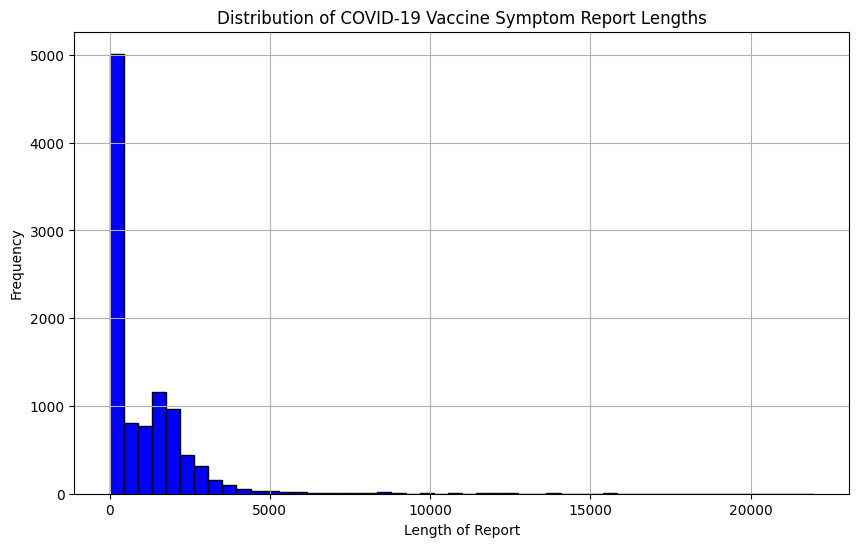

count    10000.000000
mean      1042.349700
std       1430.146538
min          2.000000
25%        113.000000
50%        439.000000
75%       1677.000000
max      21985.000000
Name: REPORT_LENGTH, dtype: float64

In [8]:
df_covid19_symptoms['SYMPTOM_TEXT'] = df_covid19_symptoms['SYMPTOM_TEXT'].astype(str)
df_covid19_symptoms['REPORT_LENGTH'] = df_covid19_symptoms['SYMPTOM_TEXT'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_covid19_symptoms['REPORT_LENGTH'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of COVID-19 Vaccine Symptom Report Lengths')
plt.xlabel('Length of Report')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

report_length_stats = df_covid19_symptoms['REPORT_LENGTH'].describe()
report_length_stats

#### d. For the reports you selected in 2.b, build the corresponding standard symptom list with the symptoms in VAERS Symptoms table. Further, please find the most common symptoms (e.g., the most frequent 100 symptoms.)

In [34]:
df_covid19_symptoms_full = pd.merge(df_covid19_symptoms[['VAERS_ID']], df_sympt, on='VAERS_ID', how='inner')
symptom_columns = [col for col in df_sympt.columns if 'SYMPTOM' in col]
df_covid19_symptoms_full['SYMPTOMS_LIST'] = df_covid19_symptoms_full[symptom_columns].values.tolist()
all_symptoms = [symptom for sublist in df_covid19_symptoms_full['SYMPTOMS_LIST'].tolist() for symptom in sublist if pd.notnull(symptom)]

def extract_unique_strings_with_count(lst):
    # Filter out strings from the list
    strings_only = [item for item in lst if isinstance(item, str)]

    # Count the frequency of each string
    string_counts = Counter(strings_only)

    # Sort the strings based on frequency in descending order
    sorted_strings = sorted(string_counts, key=string_counts.get, reverse=True)

    # Create a DataFrame with strings and their counts
    df = pd.DataFrame({
        'Symptoms': sorted_strings,
        'Count': [string_counts[string] for string in sorted_strings]
    })

    return df
# Call the function and save the result in a DataFrame
standard_symptoms = extract_unique_strings_with_count(all_symptoms)
standard_symptoms.to_csv('standard_symptoms.csv')
common_standard_symptoms = standard_symptoms.head(100)
common_standard_symptoms.to_csv('common_standard_symptoms.csv')

## STEP 1: Extracting Symptom-related Entities:
### Task:
- Input: Description of vaccine adverse events (i.e., SYMPTOM TEXT in VAERS DATA table).
- Output: A list of symptom related entities.
- Evaluation: There is no ground truth annotation for the data. You need to manually check 20+ reports to see if there are entities that are missed by the model or package.

In [11]:
stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = stanza.Pipeline(lang='en', package='mimic', processors={'ner': 'i2b2'})

2023-11-28 15:39:18 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| forward_charlm  | mimic          |
| pretrain        | mimic          |
| backward_charlm | mimic          |



2023-11-28 15:39:49 INFO: Finished downloading models and saved to /home/iar/stanza_resources.
2023-11-28 15:39:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-11-28 15:39:50 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

2023-11-28 15:39:50 INFO: Using device: cuda
2023-11-28 15:39:50 INFO: Loading: tokenize
2023-11-28 15:39:53 INFO: Loading: pos
2023-11-28 15:39:54 INFO: Loading: lemma
2023-11-28 15:39:54 INFO: Loading: depparse
2023-11-28 15:39:54 INFO: Loading: ner
2023-11-28 15:39:54 INFO: Done loading processors!


In [12]:
def extract_symptoms(text):
    doc = nlp(text)
    symptoms = []
    for ent in doc.ents:
        if ent.type in ['PROBLEM', 'DISEASE']:
            symptoms.append(ent.text)
    return symptoms

df_covid19_symptoms['EXTRACTED_SYMPTOMS'] = [extract_symptoms(text) for text in tqdm(df_covid19_symptoms['SYMPTOM_TEXT'])]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# Assuming df_covid19_symptoms has the 'EXTRACTED_SYMPTOMS' column after applying the function
for index, row in df_covid19_symptoms.head(20).iterrows():
    print(f"Report {index + 1}")
    print("Input (SYMPTOM_TEXT):", row['SYMPTOM_TEXT'])
    print("Output (Extracted Symptoms):", row['EXTRACTED_SYMPTOMS'])
    print("-" * 50)


Report 1
Input (SYMPTOM_TEXT): The adverse event is that the patient went into a coma state and was non responsive. Patient spent almost a month hospitalized and transferred into a nursing home. Trauma to the head caused severe orthostatic blood pressure problems, high fall risk, ongoing headaches, and caused patient to be exposed to covid, Be advised patient was tested the day before with a PCR 3 day covid test that resulted in zero antibodies.
Output (Extracted Symptoms): ['a coma state', 'non responsive', 'Trauma', 'severe orthostatic blood pressure problems', 'high fall risk', 'ongoing headaches', 'zero antibodies']
--------------------------------------------------
Report 2
Input (SYMPTOM_TEXT): Error: Incorrect Reconstitution-
Output (Extracted Symptoms): []
--------------------------------------------------
Report 4
Input (SYMPTOM_TEXT): Error: Dose in Series Given Too Early-
Output (Extracted Symptoms): []
--------------------------------------------------
Report 9
Input (SYMPT

In [14]:
df_covid19_symptoms.to_csv('extracted_symptoms.csv', index=False)

## STEP 2: Link Entities to Standard Symptoms
### Task: For each extracted symptom entity, map it to the term in a standard symptom list.
- Input: A symptom detected in STEP 1, Vocabulary 1 (a list of standard symptoms), Vocabulary 2 (a list of the most common standard symptoms).
- Output: Its standard symptom. For example, fever -> pyrexia, fatigue -> fatigue.
- Evaluation: You can consider using different strategies to evaluate your outcome. For example, recall can be used to evaluate the percentage of symptoms that have been missed by your models. Precision can be used to evaluate if your model has identified4 many irrelevant or incorrect symptoms. You can also define your own evaluation metrics. 

    The goal is to

    - Evaluate the performance based on standard symptom list.
    - Evaluate the performance based on the most common standard symptom list.

Make sure you have both automatic evaluation and manual evaluation. Here, for the manual
evaluation, you can select 20~50 clinical notes and manually check the results.

In [35]:
standard_symptoms

,Symptoms,Count
0,COVID-19,2847
1,No adverse event,1995
2,SARS-CoV-2 test positive,1589
3,Product storage error,1211
4,Expired product administered,1097
...,...,...
3403,Serology abnormal,1
3404,Venous pressure jugular increased,1
3405,Diabetic nephropathy,1
3406,Electrocardiogram T wave inversion,1


In [36]:
common_standard_symptoms

,Symptoms,Count
0,COVID-19,2847
1,No adverse event,1995
2,SARS-CoV-2 test positive,1589
3,Product storage error,1211
4,Expired product administered,1097
...,...,...
95,Abdominal pain,69
96,Muscular weakness,68
97,Laboratory test abnormal,68
98,Injection site pain,67


In [42]:
df_covid19_symptoms['EXTRACTED_SYMPTOMS']

0        [a coma state, non responsive, Trauma, severe ...
1                                                       []
3                                                       []
8                                                       []
10       [Considerable swelling of left hand, closure o...
                               ...                        
21533                              [temperature excursion]
21534                              [temperature excursion]
21535                              [temperature excursion]
21536                                          [dizziness]
21539    [Greatly increased tinnitus in left ear, sever...
Name: EXTRACTED_SYMPTOMS, Length: 10000, dtype: object

In [60]:
# Defining a function for fuzzy matching
def fuzzy_match(symptom, standard_list, threshold=80):
    match, score = process.extractOne(symptom, standard_list)
    return match if score >= threshold else None

def apply_fuzzy_matching_to_list(symptoms_list, standard_list):
    matched_symptoms = set()  # Use a set to automatically handle duplicates
    for symptom in symptoms_list:
        match = fuzzy_match(symptom, standard_list)
        if match:
            matched_symptoms.add(match)
    return list(matched_symptoms)  # Convert back to list

def apply_exact_matching_to_list(symptoms_list, standard_set):
    matched_symptoms = set(symptom for symptom in symptoms_list if symptom in standard_set)
    return list(matched_symptoms)

standard_symptoms_set = set(standard_symptoms['Symptoms'])
common_standard_symptoms_set = set(common_standard_symptoms['Symptoms'])


tqdm.pandas(desc="Matching Standard Symptoms")
df_covid19_symptoms['STANDARD_SYMPTOM_MATCH'] = df_covid19_symptoms['EXTRACTED_SYMPTOMS'].progress_apply(lambda x: apply_fuzzy_matching_to_list(x, list(standard_symptoms_set)))

tqdm.pandas(desc="Matching Common Standard Symptoms")
df_covid19_symptoms['COMMON_SYMPTOM_MATCH'] = df_covid19_symptoms['EXTRACTED_SYMPTOMS'].progress_apply(lambda x: apply_fuzzy_matching_to_list(x, list(common_standard_symptoms_set)))

df_covid19_symptoms.to_csv('linked_symptoms.csv', index=False)

Matching Standard Symptoms:   0%|          | 0/10000 [00:00<?, ?it/s]

In [59]:
df_covid19_symptoms['COMMON_SYMPTOM_MATCH'].head(50)

0          [Fall, Blood creatinine increased, Headache]
1                                                    []
3                                                    []
8                                                    []
10    [Pain, Inappropriate schedule of product admin...
13    [Pain, Hypertension, Headache, Heart rate incr...
14    [Inappropriate schedule of product administrat...
15                                           [Tinnitus]
16                                                   []
18    [Loss of personal independence in daily activi...
21    [Chest pain, Rash, Loss of personal independen...
23                                [Atrial fibrillation]
24                                               [Pain]
25                                            [Syncope]
28                                         [Chest pain]
29                               [Chills, Palpitations]
32    [Loss of personal independence in daily activi...
39                                              